In [221]:
'''
This file loads SEEG EDF data and plots spectra.
It's for collaboration with Ahmed, Carolina, and George starting Sept 2022, with a focus on frequency information in the centromedian (CM) nucleus.

The below Jupyter notebook has eight cells:
    I. User-defined variables
   II. Basic initializations
  III. Function definitions
   IV. Find available files
    V. Plot the spectra
   VI. Calculations for circadian plot
  VII. Plot the circadian figure
 VIII. Plot the raw data

By Mark Ebden, November/December 2022. Copyright G. Ibrahim & M. Ebden 2022.
'''

# I. User-defined variables

# A. What kind of analysis to run
plotSpectra = True # Superimpose multiple spectra each summarizing a two-minute recording
plotCircadian = True
plotTimeseries = True
verbose = False # If True, additional info is output below
bandNames = ['Delta (< 4 Hz)', 'Theta (4-7 Hz)', 'Alpha (8-12 Hz)', 'Beta (13-30 Hz)', 'Gamma (> 30 Hz)']
bandFreqs = [0, 3.5, 7.5, 12.5, 30.5, 2000]


# B. Which patient's data to use
patient = 1
fileRoot = '/d/gmi/r1/EEG/seeg/'
from datetime import datetime # Required to define midnights below
if patient == 1:
    dirName = 'anja' # Where to search for EDF files
    plotTitle = 'Anja (5052609, CLAS_029)'
    inputStart = 'anj_ona_' # How each file begins
    groupings = ['d1_', 'd2_', 'n2_']
    groupNames = ['Day 1', 'Day 2', 'Night 2']
    legendPos = 'upper right'
    mid1 = datetime.fromisoformat('2022-01-25T00:00:00')
    mid2 = datetime.fromisoformat('2022-01-26T00:00:00')
elif patient == 2:
    dirName = 'anabella' # Where to search for EDF files
    plotTitle = 'Anabella (5109130)'
    inputStart = 'ana_ona_' # How each file begins
    groupings = ['n1_', 'd2_', 'n2_']
    groupNames = ['Night 1', 'Day 2', 'Night 2']
    legendPos = 'upper left'
    mid1 = datetime.fromisoformat('2022-08-16T00:00:00')
    mid2 = mid1
else:
    dirName = 'massimo' # Where to search for EDF files
    plotTitle = 'Massimo (2521079, CLAS_037)'
    inputStart = 'mass_ona_' # How each file begins
    groupings = ['n1_', 'd2_', 'n2_']
    groupNames = ['Night 1', 'Day 2', 'Night 2']
    legendPos = 'upper right'
    mid1 = datetime.fromisoformat('2022-09-20T00:00:00')
    mid2 = datetime.fromisoformat('2022-09-21T00:00:00')
    #xlim = 30; ylim = [0,2e-5] # Graphing limits for linear setup
inputRoot = fileRoot + dirName + '/'
savedImageName = '/d/gmi/1/markebden/c/output/seeg2/' + dirName

# C. Which channel to use
# If you desire monopoles:
#channelTexts = ['LCMT', 'DPH', 'CMN'] # What channel is of interest. e.g. LCMT1 is the left centromedian nucleus, and 'LANT1' for anterior nucleus.
##channelTexts = ['LANT'] # Extra info, for Anja
#chanTexts = [x + '1' for x in channelTexts] # '1' is the contact number; use '1' for the CM.
# If you desire dipoles:
chanTexts = ['LCMT1-LCMT2', 'DPH1-DPH2', 'CMN1-CMN2']
chanTexts = ['LANT1-LANT2']

# D. Plotting decisions
numSeconds = 0 # How many seconds of raw data to plot in the time series in part VIII. Set to 0 to plot data at *all* time points.
#xlim = [0.7, 500]; ylim = [6e-9, 2e-5] # Graphing limits for logarithmic setup, for original calcFFT (not Welch)
xlim = [2, 800]; ylim = [5e-15, 5.5e-10] # similar but for windowed version, calcPSD
#yMax = 0.0058 # Highest magnitude in circadian plot (for original calcFFT)
logging = True # True for logarithmic scales on the spectral plots
fig1width = 16; fig1height = 6  # Figure dimensions for first plot per patient (spectrum), in inches
fig2width = 12; fig2height = 4.5  # For circadian plot
legSz = 11 # Font size to use in legend
palette = ['Olive', 'Teal', 'Brown', 'Orchid', 'Purple', 'Maroon', 'Olive', 'Orange', 'Lime', 'Blue', 'Cyan', 'Magenta'] # Basic eight types of lines. The second 'Olive' can be replaced with 'Lavender' but the latter is harder to read on some screens.
bandColours = palette[0:len(bandNames)]
seizCol = 'red' # What colour to use for seizures
sleepCol = 'black' # Colour to use for sleep

In [222]:
# II. Basic initializations

# A. Libraries
import os, sys
import mne
import scipy
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, ScalarFormatter) # For selective tick labels
import matplotlib.dates

# B. Import Nebras's functions to load EDF files etc.
os.chdir('/d/gmi/1/nebraswarsi/Network Analysis/scripts/')
import datafuncs
# Optional: return to current directory
# os.chdir('/d/gmi/1/markebden/c/py/seeg/')

# C. Format the notebook output
pd.set_option("display.max_rows", 5000) # ‘None’ value means unlimited. These two rows are useful for debugging.
pd.set_option('display.width', 1000)


In [223]:
# III. Define functions

# 1. Extract from array 'allData' one channel (integer 'channelNumber') from over 100 available options.  Process it.
def extractChannel (allData, channelNumber):
    y = allData[channelNumber]
    #y = y[150:-150]
    y = y - np.mean(y)
    return y

# 2. Find unwindowed spectral info from a time series y with sampling frequency Fs
def calcFFT (y, Fs):

    T = 1/Fs
    N = len(y)
    yf = scipy.fft.fft(y)
    xf = scipy.fft.fftfreq(N, T)[:N//2]
    plotyf = 2.0/N * np.abs(yf[0:N//2])
    
    return xf, plotyf, len(xf)

# 3. Find spectral info from a time series y with sampling frequency Fs
def calcPSD (y, Fs):
    Nwindow = 1024
    xf, plotyf = scipy.signal.welch(x=y, fs=Fs, window='hamming', nperseg=Nwindow, noverlap=Nwindow//2)
    
    # MNE-based way; incomplete
    #plotyf, xf = mne.time_frequency.psd_welch(inst=..., n_fft=256, n_overlap=128)
    
    return xf, plotyf, len(xf)

# 4. Choose the layout of a subfigure matrix (e.g. 2 x 3 images), given a number of images required (e.g. 6)
def findGrid(x):
    if x < 4:
        dims = [1,x]
    elif x == 4:
        dims = [2,2]
    elif x < 7:
        dims = [2,3]
    elif x < 10:
        dims = [3,3]
    elif x < 13:
        dims = [3,4]
    elif x < 17:
        dims = [4,4]
    else:
        dims = [5,5] # hopefully not used
    return dims


In [224]:
# IV. Find available files

# 1. Initialize empty lists
fileNames = [] # A growing list of unique filenames
origFilenames = []
timestamps = []

# 2. Create a list of files
oswalk = os.walk(inputRoot)
for root, dirs, files in oswalk:
    for file in files:
        edf_file = os.path.join(root, file)
        edf_fileTemp = edf_file.split(inputStart)
        if len(edf_fileTemp) > 1:
            origFilenames.append(edf_file)
            raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True) # Inspired by Nebras's datafuncs.py
            timestamps += [raw_data.info['meas_date']]
if len(origFilenames) > 0:
    Fs = raw_data.info['sfreq'] # Should be 2048
else:
    print("No files found.")
    sys.exit(1)

# 3. Sort files by measurement date
newIndices = np.argsort(timestamps)
fullFilenames = [origFilenames[i] for i in newIndices]
timestamps.sort()

# 4. Create abbreviated filenames
numFiles = len(fullFilenames)
for fileNum in range(numFiles):
        edf_fileTemp = fullFilenames[fileNum].split(inputStart)
        if len(edf_fileTemp) > 1:
            edf_file = edf_fileTemp[1]
            fileNames.append(edf_file[:-4])

# 5. Characterize the data extent
numGroups = len(groupings)
numTexts = len(chanTexts)

/tmp/ipykernel_3686394/1531335649.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True) # Inspired by Nebras's datafuncs.py
/tmp/ipykernel_3686394/1531335649.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True) # Inspired by Nebras's datafuncs.py
/tmp/ipykernel_3686394/1531335649.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True) # Inspired by Nebras's datafuncs.py
/tmp/ipykernel_3686394/1531335649.py:16: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True) # Inspired by Nebras's datafuncs.py
/tmp/ipykernel_3686394/1531335649.py:16: RuntimeWarning: Limited 1 a

/tmp/ipykernel_3686394/3979107835.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3979107835.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3979107835.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3979107835.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3979107835.py:19: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_

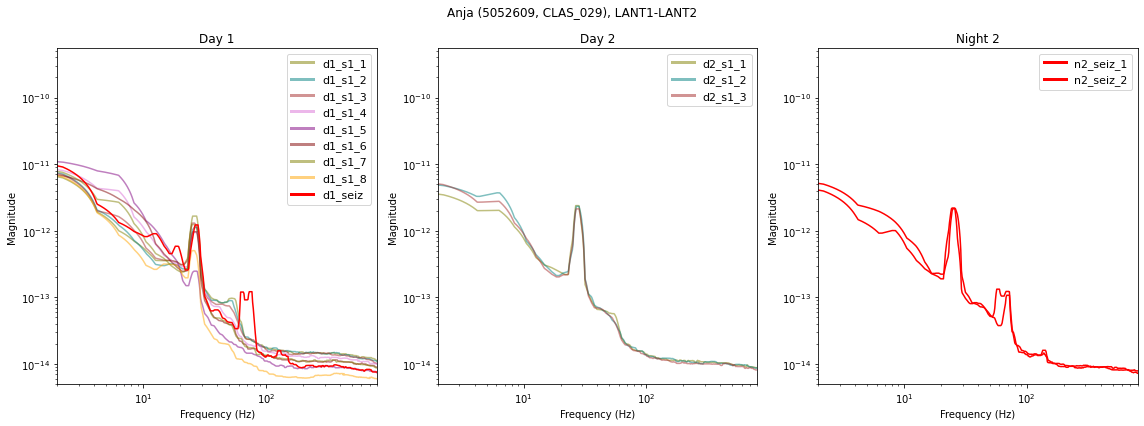

In [225]:
# V. Plot the spectra
 
if plotSpectra:
    durations = []
    fig1 = plt.figure(1, figsize=(fig1width,fig1height))
    figDim = findGrid(numGroups)

    for groupNum in range(numGroups):
        axs = fig1.add_subplot(figDim[0], figDim[1],groupNum+1) 
        
        # 1. Prepare for plotting
        lineInd = 0 # Each line on the subplot will have an index from 0 upwards
        specHandles = []
        for fileNum in range(numFiles):
            if groupings[groupNum] in fileNames[fileNum]:

                # 2. Load data
                edf_file = fullFilenames[fileNum]
                raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
                raw_data = mne.set_bipolar_reference(raw_data, 
                            anode=raw_data.ch_names[:-1], cathode=raw_data.ch_names[1:], verbose='warning')
                durations += [round(raw_data._data.shape[1] / raw_data.info['sfreq'])]
                nameInd = 0
                while nameInd < numTexts:
                    chanText = chanTexts[nameInd]
                    if chanText in raw_data.ch_names:
                        # 3. Calculate spectrum for one channel
                        chanIndex = raw_data.ch_names.index(chanText) # Counting up from 0, not from 1 as in the EDF
                        dataAllChannels = raw_data.get_data() # array in which each row is a channel, and columns are time
                        y = extractChannel(dataAllChannels,chanIndex)
                        xf, plotyf, N = calcPSD(y, Fs)

                        # 4. Plot spectra
                        fileSuffix = fileNames[fileNum]
                        if 'seiz' in fileSuffix:
                            chanCol = seizCol
                            transp = 1
                        else:
                            chanCol = palette[lineInd]
                            transp = 0.5

                        newLine = mlines.Line2D([],[], color = chanCol, marker = 'o', linewidth=3, markersize = 0, alpha = transp, label = fileSuffix)
                        specHandles.append(newLine)
                        
                        if logging:
                            newx = np.logspace(np.log10(xf[1]), np.log10(np.nanmax(xf)*0.999), 500, endpoint = True)
                            myfcn = interp1d(xf, plotyf)
                            newy = myfcn(newx)
                            # Calculate rolling median window over the spectrum.
                            windowSize = 9
                            s = pd.Series(newy)
                            newy = s.rolling(windowSize, min_periods=1).median()
                            # plot it
                            axs.plot(newx, newy, color=chanCol, alpha=transp) 
                        else:
                            # Calculate and plot rolling median window over the spectrum - we want the median each 0.7 Hz or so (comfortably below the 1 Hz Medtronic uses as bin size). 
                            # So if 125 Hz coverage, want 200 bins.  1000 Hz -> 1500 bins... 
                            windowSize = int(np.ceil(N/2/(0.75*Fs)))
                            s = pd.Series(plotyf)
                            plotyf = s.rolling(windowSize, min_periods=1).median()
                            axs.plot(xf, plotyf, color=chanCol, alpha=transp)            
                        lineInd += 1
                        nameInd += 10 # abort
                    nameInd += 1
                if lineInd == 0:
                    print ('Not found in:')
                    print (raw_data.ch_names)

        # 5. Touch up the graph, if it exists
        if lineInd > 0:
            axs.set_xlabel('Frequency (Hz)')
            axs.set_ylabel('Magnitude')

            if logging: # log plotting
                axs.set_yscale('log')
                axs.set_xscale('log')
                #axs.yaxis.set_major_formatter(ScalarFormatter())  # Removes scientific notation
                #axs.yaxis.set_minor_formatter(ScalarFormatter())  # Removes scientific notation
            axs.set_ylim(ylim[0],ylim[1])   
            axs.set_xlim(xlim[0],xlim[1])     
            axs.set_title(groupNames[groupNum])
            axs.legend(loc="upper right", handles=specHandles, fontsize=legSz)

    fig1.suptitle(plotTitle + ', ' + chanText)
    fig1.tight_layout()
    fig1.savefig(savedImageName + '_' + chanText + '_spectra.png', bbox_inches='tight', transparent=False)
            

In [226]:
# VI. Calculations for circadian plot

numBands = len(bandNames)
if plotCircadian:
    durations = []

    # 1. Prepare for plotting
    lineInd = 0 # Each line on the subplot will have an index from 0 upwards
    specHandles = []
    ySums = [[0 for col in range(numBands)] for row in range(numFiles)]
    for fileNum in range(numFiles):

        # 2. Load data
        edf_file = fullFilenames[fileNum]
        raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
        raw_data = mne.set_bipolar_reference(raw_data, anode=raw_data.ch_names[:-1], cathode=raw_data.ch_names[1:], verbose='warning')

        Fs = raw_data.info['sfreq'] # Should be 2048
        durations += [round(raw_data._data.shape[1] / raw_data.info['sfreq'])]
        nameInd = 0
        while nameInd < numTexts:
            chanText = chanTexts[nameInd]
            if chanText in raw_data.ch_names:
                # 3. Calculate spectrum for one channel
                chanIndex = raw_data.ch_names.index(chanText) # Counting up from 0, not from 1 as in the EDF
                dataAllChannels = raw_data.get_data() # array in which each row is a channel, and columns are time
                y = extractChannel(dataAllChannels,chanIndex)
                xf, plotyf, N = calcPSD(y, Fs)
                lineInd += 1
                nameInd += 10 # abort loop
            nameInd += 1
        if lineInd == 0 and verbose:
            print ('Not found in:')
            print (raw_data.ch_names)

        # 4. Calculate bands
        ySum = [0]*numBands
        for bandInd in range(numBands):
            leftEdge = bandFreqs[bandInd]
            rightEdge = bandFreqs[bandInd+1]
            yBand = [plotyf[i] for i in range(N) if xf[i] >= leftEdge and xf[i] < rightEdge] 
            ySums[fileNum][bandInd] = np.sum(yBand)
        
    # 5. Normalize bands, to show relative (not absolute) changes as percentage
    # a) Loop through each band and timepoint, to find the mean
    for bandInd in range(numBands):
        yMean = 0
        for fileNum in range(numFiles):
            yMean += ySums[fileNum][bandInd] / numFiles
        # b) Divide by mean
        for fileNum in range(numFiles):
            ySums[fileNum][bandInd] = ySums[fileNum][bandInd] / yMean * 100
  

/tmp/ipykernel_3686394/3427765854.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3427765854.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3427765854.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3427765854.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/3427765854.py:15: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_

/tmp/ipykernel_3686394/4089089981.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs.plot_date(dates, yColumn, color=bandColours[bandInd], marker='o', linestyle='solid')
/tmp/ipykernel_3686394/4089089981.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs.plot_date(dates, yColumn, color=bandColours[bandInd], marker='o', linestyle='solid')
/tmp/ipykernel_3686394/4089089981.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  axs.plot_date(dates, yColumn, color=bandColours[bandInd], marker='o', linestyle='solid')
/tmp/ipykernel_3686394/4089089981.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fm

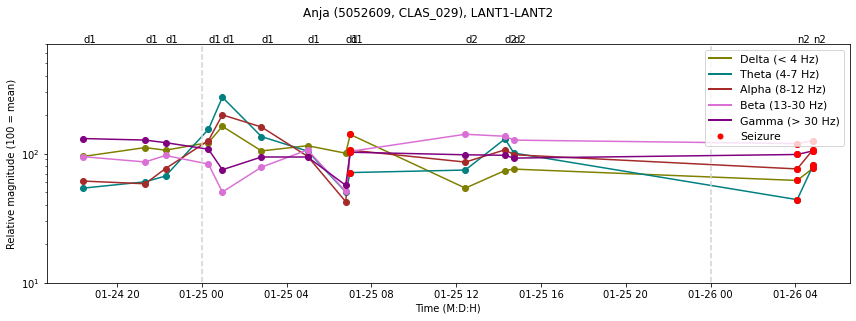

In [227]:
# VII. Plot the circadian figure
if plotCircadian: 

    # 1. Create the figure
    fig2 = plt.figure(2, figsize=(fig2width,fig2height))
    axs = fig2.add_subplot() 
    
    # 2. Plot time series and build legend
    dates = matplotlib.dates.date2num(timestamps)
    fig2handles = []
    for bandInd in range(numBands):
        yColumn = [row[bandInd] for row in ySums]
        axs.plot_date(dates, yColumn, color=bandColours[bandInd], marker='o', linestyle='solid')
        newLine = mlines.Line2D([],[], color = bandColours[bandInd], linewidth=2, markersize = 0, label = bandNames[bandInd])
        fig2handles.append(newLine)

    # 3. Colour seizure dots red
    newLine = mlines.Line2D([],[], color = seizCol, marker = "o", linewidth=0, markersize = 5, label = "Seizure")
    fig2handles.append(newLine)
    hasSleep = False
    for fileNum in range(numFiles):
        fileSuffix = fileNames[fileNum]
        if 'seiz' in fileSuffix:
            yRow = ySums[fileNum]
            seizDates = [dates[fileNum]]*numBands
            axs.plot_date(seizDates, yRow, color=seizCol, marker='o')
        if 'sleep' in fileSuffix:
            yRow = ySums[fileNum]
            seizDates = [dates[fileNum]]*numBands
            axs.plot_date(seizDates, yRow, color=sleepCol, marker='v', markersize=11)
            hasSleep = True
    if hasSleep:
        newLine = mlines.Line2D([],[], color = sleepCol, marker = "v", linewidth=0, markersize = 10, label = "Sleep")
        fig2handles.append(newLine)

    # 4. Add night/day text
    #ignore, yMax = axs.get_ylim()
    yMax = 700
    axs.set_ylim(10,yMax)
    for fileNum in range(numFiles):
        filePrefix = fileNames[fileNum][0:2]
        axs.text(timestamps[fileNum], yMax*1.02, filePrefix)

    # 5. Add midnights
    axs.plot_date([mid1, mid1], [0, yMax], color='lightgrey', linestyle='dashed', markersize=0)
    axs.plot_date([mid2, mid2], [0, yMax], color='lightgrey', linestyle='dashed', markersize=0)

    # 6. Tidy and save the figure
    axs.legend(handles = fig2handles, loc=legendPos, fontsize=legSz, title='')
    axs.set_xlabel('Time (M:D:H)')
    axs.set_ylabel('Relative magnitude (100 = mean)')
    axs.set_yscale('log')
    fig2.suptitle(plotTitle + ', ' + chanText)
    fig2.tight_layout()
    fig2.savefig(savedImageName + '_' + chanText + '_circadian.png', bbox_inches='tight', transparent=False)


/tmp/ipykernel_3686394/904261389.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/904261389.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/904261389.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/904261389.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_3686394/904261389.py:14: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
/tmp/ipykernel_36863

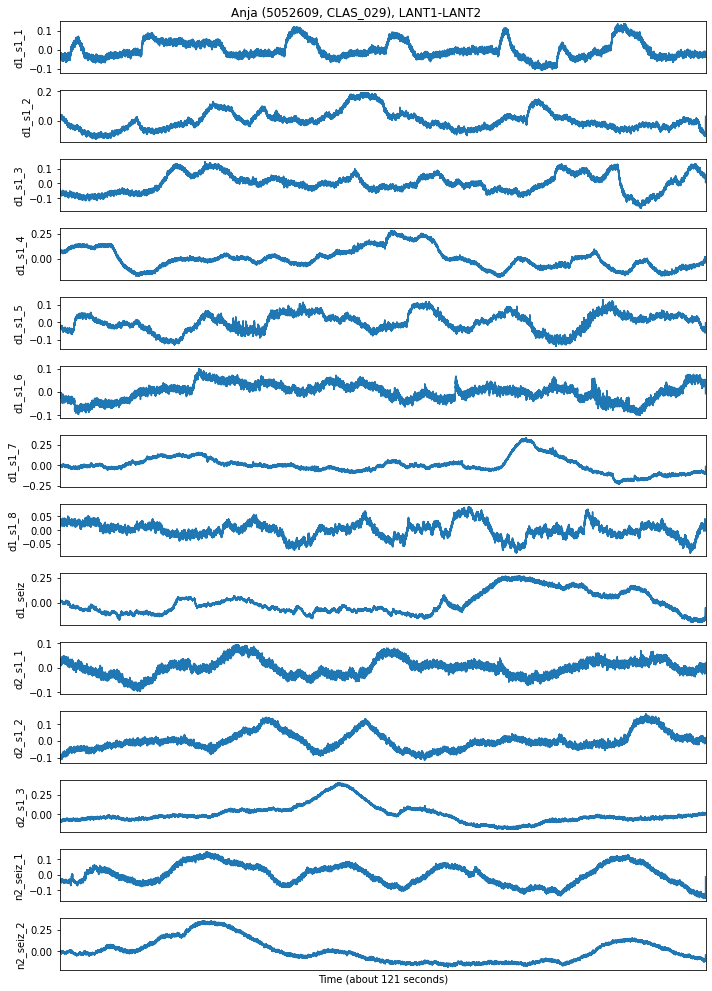

In [228]:
# VIII. Plot the raw data

if plotTimeseries:
    fig3width=10
    fig3height=numFiles
    # 1. Prepare for plotting
    fig3 = plt.figure(3, figsize=(fig3width,fig3height))
    figDim = [numFiles,1]
    
    for fileNum in range(numFiles):
        
        # 2. Load data
        edf_file = fullFilenames[fileNum]
        raw_data = mne.io.read_raw_edf(edf_file, verbose=False, preload=True)
        raw_data = mne.set_bipolar_reference(raw_data, anode=raw_data.ch_names[:-1], cathode=raw_data.ch_names[1:], verbose='warning')
        Fs = int(raw_data.info['sfreq']) # Should be 2048
        durations = round(raw_data._data.shape[1] / raw_data.info['sfreq'])
        lineInd = 0 # misnomer
        nameInd = 0
        while nameInd < numTexts:
            chanText = chanTexts[nameInd]
            if chanText in raw_data.ch_names:
                # 3. Get data from one channel
                chanIndex = raw_data.ch_names.index(chanText) # Counting up from 0, not from 1 as in the EDF
                dataAllChannels = raw_data.get_data() # array in which each row is a channel, and columns are time
                y = extractChannel(dataAllChannels,chanIndex)
                if numSeconds > 0: # Truncate the signal if requested
                    y = y[Fs:(Fs*numSeconds)]
                lineInd += 1
                nameInd += 10 # abort
            nameInd += 1
        if lineInd == 0 and verbose:
            print ('Not found in:')
            print (raw_data.ch_names)
        else:
            # 4. Create plot
            axs = fig3.add_subplot(figDim[0], figDim[1],fileNum+1)
            axs.plot([i*1000 for i in y])
            axs.set_ylabel(fileNames[fileNum])
            axs.set_xlim(0, len(y))
            axs.set_xticks([]) # remove x ticks

    # 5. Touch up the plot
    durations = int(round(len(y)/Fs))
    axs.set_xlabel('Time (about ' + str(durations) + ' seconds)') # only set x label once
    fig3.suptitle(plotTitle + ', ' + chanText)
    fig3.tight_layout()
    fig3.savefig(savedImageName + '_' + chanText + '_raw_5sec.png', bbox_inches='tight', transparent=False)
